In [53]:
import pandas as pd
import numpy as np
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
import pickle
from scipy.stats import bootstrap
from script import create_time_series
from fsrs_optimizer import Optimizer, Trainer
from fsrs_optimizer import Collection, power_forgetting_curve, rmse_matrix
from collections import defaultdict
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

lr: float = 4e-2
n_epoch: int = 5
batch_size: int = 512
# look_ahead: int = 100  # Number of reviews between optimisations. Moved to the function call
verbose: bool = False
optimizer = Optimizer()
cache = None

def get_res_cached(file, look_ahead):
    global cache
    if cache is None:
        try:
            with open('minimum_limit_cache.pckl', 'rb') as f:
                cache = pickle.load(f)
        except FileNotFoundError:
            print("No cache found")
            cache = {}
    if (file, look_ahead) in cache:
        return cache[(file, look_ahead)]
    return None

def add_to_cache(key, value):
    global cache
    assert cache is not None
    cache[key] = value
    if len(cache) % 50 == 0:
        save_cache()
        print("Cache saved")

def save_cache():
    global cache
    with open('minimum_limit_cache_temp.pckl', 'wb') as f:
        pickle.dump(cache, f)
    try:
        os.remove('minimum_limit_cache.pckl')
    except FileNotFoundError:
        pass
    os.rename('minimum_limit_cache_temp.pckl', 'minimum_limit_cache.pckl')

def plot_file(file, look_ahead, cumulative_data=None, plot_individual=False, plot_cumulative=False, look_aheads=None):
    global cache
    if cumulative_data is None:
        cumulative_data = [[], [], []]
    if look_aheads is None:
        look_aheads = [look_ahead]  # Can run extra lookaheads in the same call
    
    cache_res_all = [get_res_cached(file, this_look_ahead) for this_look_ahead in look_aheads]
    if None not in cache_res_all:
        cache_res = get_res_cached(file, look_ahead)
        assert cache_res is not None
        rmses, loglosses, indexes = cache_res
    else:
        dataset = pd.read_csv(file)[:5000]
        dataset = create_time_series(dataset).reset_index()
        optimized_list = []
        dry_run_list = []
        pretrain_list = []
        testsets_all = [[] for _ in range(len(look_aheads))]

        if len(dataset) < 8:
            raise Exception("Dataset too small")

        max_pow = np.floor(np.log2(len(dataset)))

        indexes = [2**i for i in range(3, int(max_pow) + 1)]
        indexes = [i for i in indexes if i <= 4096]
        # print(indexes)

        for max_index in indexes:
            train_set = dataset.loc[:max_index].copy()
            for i, this_look_ahead in enumerate(look_aheads):
                test_set = dataset.loc[max_index : min(max_index + this_look_ahead + 1, len(dataset) - 1)].copy()
                testsets_all[i].append(test_set)
            optimizer.define_model()
            dry_run_list.append(optimizer.init_w.copy())

            optimizer.S0_dataset_group = (
                train_set[train_set["i"] == 2]
                .groupby(by=["r_history", "delta_t"], group_keys=False)
                .agg({"y": ["mean", "count"]})
                .reset_index()
            )
            _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
            pretrain_list.append(optimizer.init_w.copy())

            try:
                trainer = Trainer(
                    train_set,
                    None,
                    optimizer.init_w,
                    n_epoch=n_epoch,
                    lr=lr,
                    batch_size=batch_size,
                )
                optimized_list.append(trainer.train(verbose=verbose))
            except Exception as e:
                if str(e) != "Training data is inadequate.":
                    print(e)
                optimized_list.append(optimizer.init_w.copy())

        for this_look_ahead, testsets in zip(look_aheads, testsets_all):
            rmses = defaultdict(list)
            loglosses = defaultdict(list)
            for i, (w1, w2, w3, testset) in enumerate(zip(optimized_list, pretrain_list, dry_run_list, testsets)):
                for j, w in enumerate((w1, w2, w3)):
                    my_collection = Collection(w)
                    stabilities, difficulties = my_collection.batch_predict(testset)
                    testset["p"] = power_forgetting_curve(testset["delta_t"], stabilities)
                    rmse = rmse_matrix(testset)
                    rmses[j].append(rmse)
                    logloss = log_loss(testset["y"], testset["p"], labels=[0, 1])
                    loglosses[j].append(logloss)

            add_to_cache((file, this_look_ahead), (rmses, loglosses, indexes))

        cache_res = get_res_cached(file, look_ahead)
        assert cache_res is not None
        rmses, loglosses, indexes = cache_res

    if plot_individual:
        # Same but using a plt figure: fig = plt.figure(figsize=(12, 5))
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(indexes, rmses[0], label="optimised")
        ax.plot(indexes, rmses[1], label="pretrain")
        ax.plot(indexes, rmses[2], label="dry_run")
        ax.set_title("RMSE")
        ax.set_ylim(0, max(rmses[0] + rmses[1] + rmses[2]))
        ax.semilogx()
        ax.legend()
        plt.show()

    # Cumulative version
    cumulative_data[0].append(rmses[0])
    cumulative_data[1].append(rmses[1])
    cumulative_data[2].append(rmses[2])
    cumulative_means = [[], [], []]
    cumulative_vals = [[], [], []]
    for i in range(3):
        this_vals = [[] for _ in range(len(indexes))]
        for this_rmses in cumulative_data[i]:
            for j, rmse in enumerate(this_rmses):
                if j >= len(indexes):
                    break
                this_vals[j].append(rmse)
        for j in range(len(indexes)):
            cumulative_means[i].append(np.mean(this_vals[j]))
            cumulative_vals[i].append(this_vals[j])

    if plot_cumulative:
        print("""


Very important note:
With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for a while.
For the second set of graphs:               n=8 has lookahead 100.  IQR is now less representative because we're optimising on 8 reviews then testing on 100 (100 reviews with a single optimisation after 8 reviews!). The test losses aren't very accurate because of this.
For the third set of graphs:                n=8 has lookahead 1000. The losses of n=8 are now meaningless. (1000 reviews with a single optimisation after 8 reviews!)
              
To summarise: The analyses suggest pretrain works great on all n. It's just hard to show it through IQR because a larger test dataset means less accurate losses. Lookahead 10 shows it quite well, and mean log loss vs mean rmse shows it even better. (Log loss penalises being very wrong more than RMSE).


        """)

        fig, ax = plt.subplots(figsize=(8, 6))
        
        ax.plot(indexes, cumulative_means[0], label="optimised")
        ax.plot(indexes, cumulative_means[1], label="pretrain")
        ax.plot(indexes, cumulative_means[2], label="dry_run")

        # Shade between IQR
        # highest_y = 0
        # for i in range(3):
        #     lower = [np.percentile(e, 25, axis=0) for e in cumulative_vals[i]]
        #     upper = [np.percentile(e, 75, axis=0) for e in cumulative_vals[i]]
        #     highest_y = max(highest_y, max(upper))
        #     ax.fill_between(indexes, lower, upper, alpha=0.2)  # type: ignore

        # Shade confidence intervals
        lowest_y = np.inf
        highest_y = 0
        for i in range(3):
            # Calculate 95% CI for each bin
            means_ci = [bootstrap((l,), np.mean, confidence_level=0.95, method="BCa").confidence_interval for l in cumulative_vals[i]]
            lower = [e[0] for e in means_ci]
            upper = [e[1] for e in means_ci]
            lowest_y = min(lowest_y, min(lower))
            highest_y = max(highest_y, max(upper))
            ax.fill_between(indexes, lower, upper, alpha=0.2)  # type: ignore


        ax.set_title(f"Averaged RMSE over {len(cumulative_data[0])} collection" + ('s' if len(cumulative_data[0]) > 1 else '') + f" with lookahead {look_ahead}")
        ax.set_ylim(lowest_y, highest_y)
        ax.semilogx()
        ax.set_xlabel("Size")
        ax.set_ylabel("Average RMSE")
        ax.legend()
        plt.show()

        # Plot differences
        for i, (model_i, model_compare_i) in enumerate([(0,2), (1,2), (0,1)]):
            fig, ax = plt.subplots(figsize=(8, 6))
            diffs = [np.array(cumulative_vals[model_compare_i][j]) - np.array(cumulative_vals[model_i][j]) for j in range(len(indexes))]

            # Keep only if enough data
            diffs_to_keep_i = [j for j, e in enumerate(diffs) if len(e) > 200]
            diffs = [diffs[j] for j in diffs_to_keep_i]
            indexes = [indexes[j] for j in diffs_to_keep_i]

            # Plot IQRs
            diffs_means = [np.mean(e) for e in diffs]
            diffs_lower = [np.percentile(e, 25) for e in diffs]
            diffs_upper = [np.percentile(e, 75) for e in diffs]
            ax.plot(indexes, diffs_means)
            ax.fill_between(indexes, diffs_lower, diffs_upper, alpha=0.3)  # type: ignore

            # Dotted line at y=0
            ax.axhline(0, color='black', linestyle='--')

            # Set limits so y=0 is centred
            ax.set_ylim(-max([abs(e) for e in diffs_lower+diffs_upper]), max([abs(e) for e in diffs_lower+diffs_upper]))

            ax.set_title(f"How much better '{['optimised', 'pretrain', 'dry_run'][model_i]}' is than '{['optimised', 'pretrain', 'dry_run'][model_compare_i]}', Lookahead {look_ahead}, {len(cumulative_data[0])} collections")
            ax.semilogx()
            ax.set_xlabel("Size")
            ax.set_ylabel("RMSE difference")
            plt.show()

    return (rmses[0], rmses[1], rmses[2]), cumulative_data

Graph 577 Error: Dataset too small
Graph 1227 Error: Training data is inadequate.
Graph 1616 Error: Training data is inadequate.
Graph 1838 Error: Training data is inadequate.
Graph 2000 


Very important note:
With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for

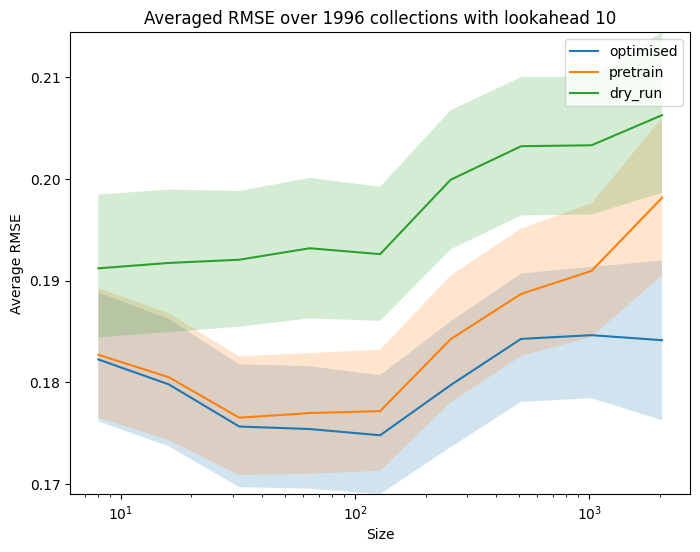

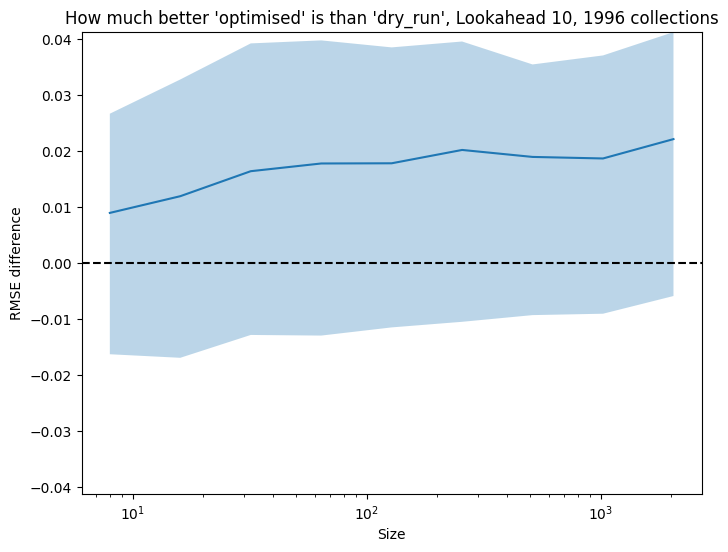

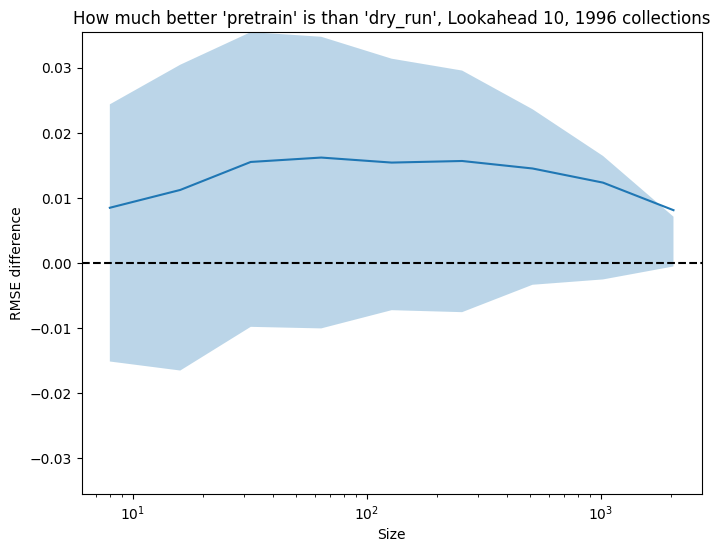

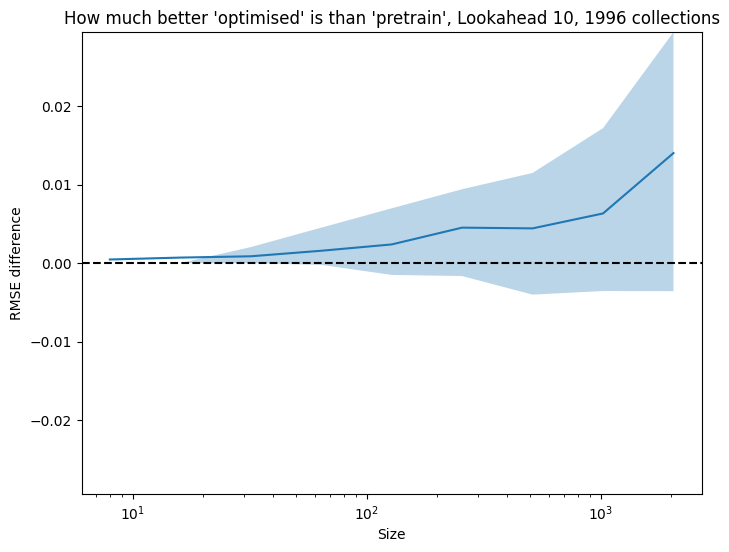

In [54]:
plt.rcParams.update(plt.rcParamsDefault)
amt_to_do = 2000
look_ahead = 10

cumulative_data = [[], [], []]
for i in range(amt_to_do):
    print('\rGraph', i+1, '', end='')
    try:
        _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=look_ahead, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=(i+1)==amt_to_do)#, look_aheads=[3, 5, 10, 25, 50, 100, 250, 500, 1000])
    except Exception as e:
        print('Error:', e)
save_cache()

Graph 577 Error: Dataset too small
Graph 1227 Error: Training data is inadequate.
Graph 1616 Error: Training data is inadequate.
Graph 1838 Error: Training data is inadequate.
Graph 2000 


Very important note:
With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for

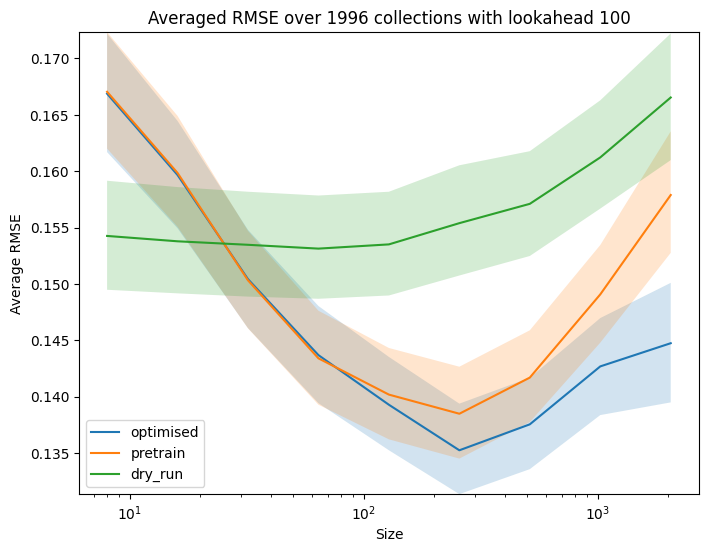

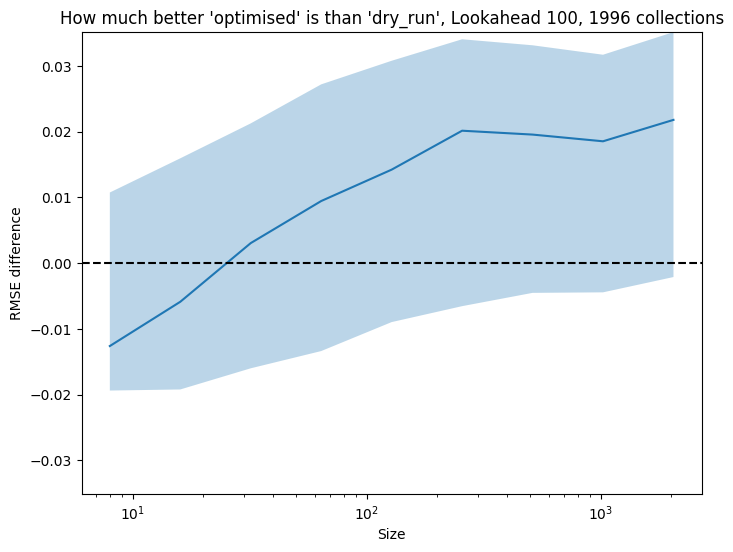

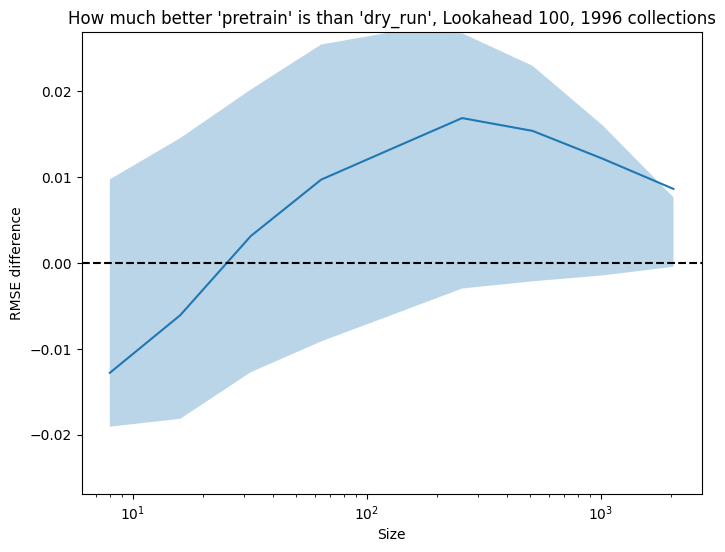

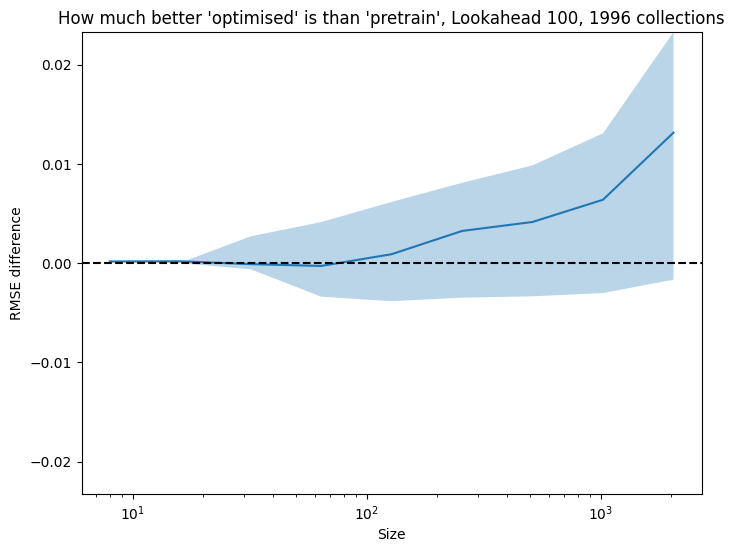

In [55]:
plt.rcParams.update(plt.rcParamsDefault)
amt_to_do = 2000
look_ahead = 100

cumulative_data = [[], [], []]
for i in range(amt_to_do):
    print('\rGraph', i+1, '', end='')
    try:
        _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=look_ahead, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=(i+1)==amt_to_do)#, look_aheads=[3, 5, 10, 25, 50, 100, 250, 500, 1000])
    except Exception as e:
        print('Error:', e)
save_cache()

Graph 577 Error: Dataset too small
Graph 1227 Error: Training data is inadequate.
Graph 1616 Error: Training data is inadequate.
Graph 1838 Error: Training data is inadequate.
Graph 2000 


Very important note:
With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for

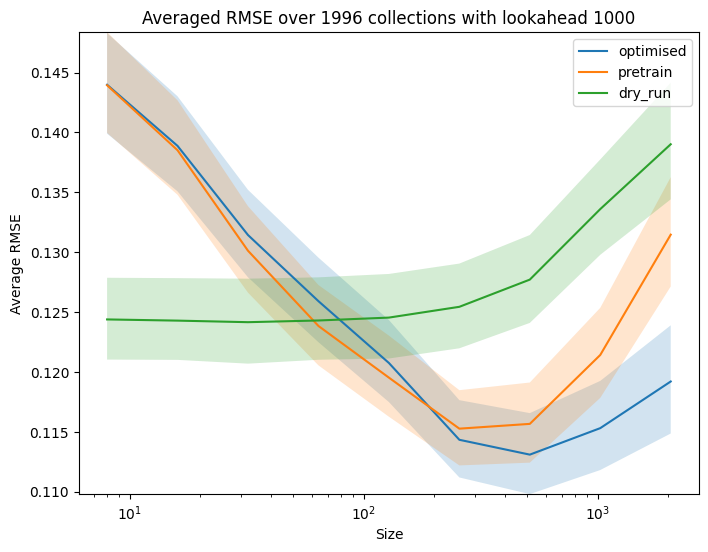

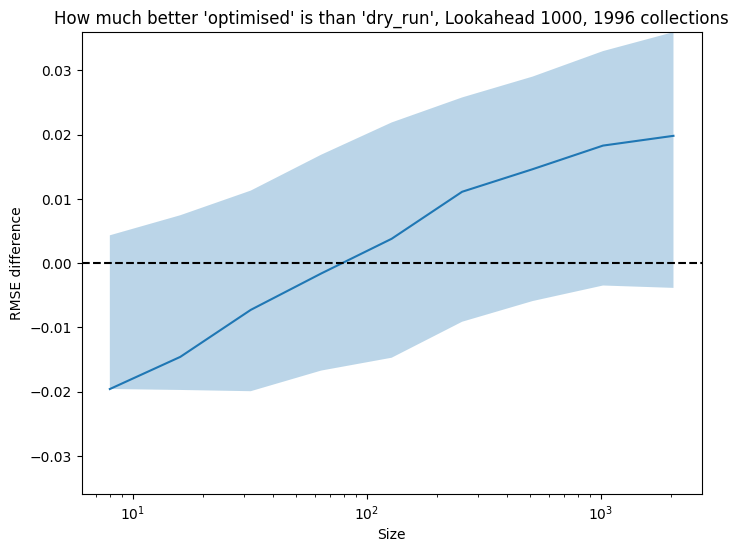

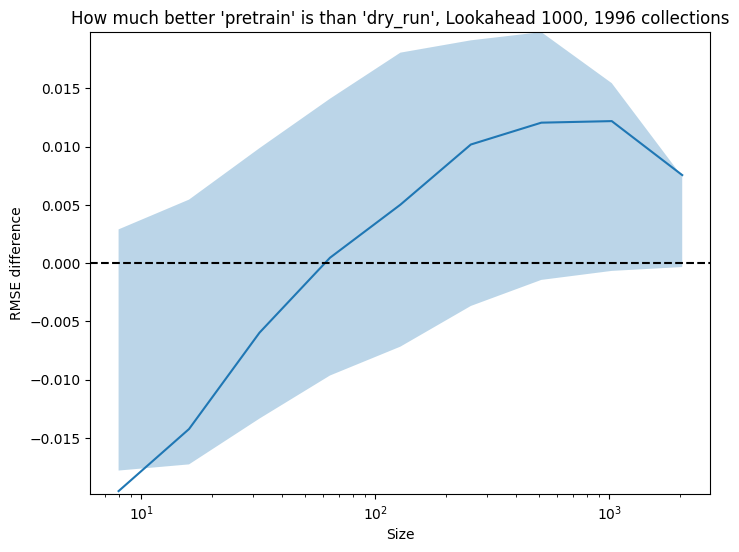

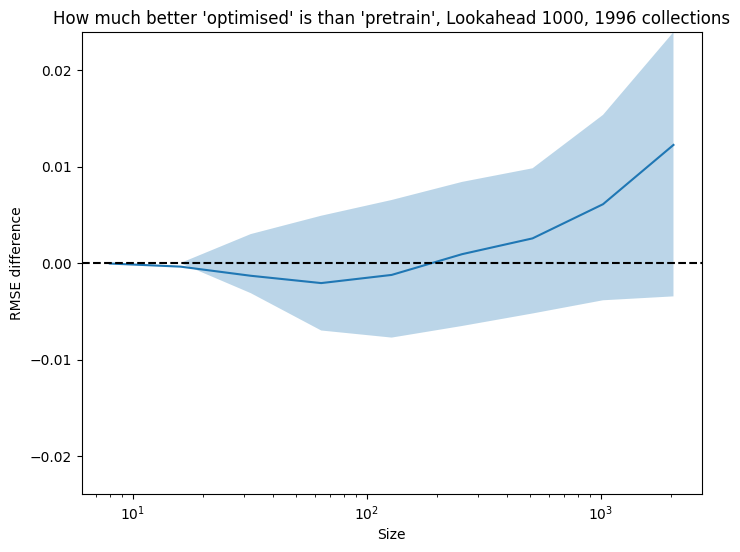

In [56]:
plt.rcParams.update(plt.rcParamsDefault)
amt_to_do = 2000
look_ahead = 1000

cumulative_data = [[], [], []]
for i in range(amt_to_do):
    print('\rGraph', i+1, '', end='')
    try:
        _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=look_ahead, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=(i+1)==amt_to_do)#, look_aheads=[3, 5, 10, 25, 50, 100, 250, 500, 1000])
    except Exception as e:
        print('Error:', e)
save_cache()

Graph 577 Error: Dataset too small
Graph 1227 Error: Training data is inadequate.
Graph 1616 Error: Training data is inadequate.
Graph 1838 Error: Training data is inadequate.
Graph 2000 
The high ends (worst case scenarios) are reduced by optimised FSRS, especially at higher n(reviews)


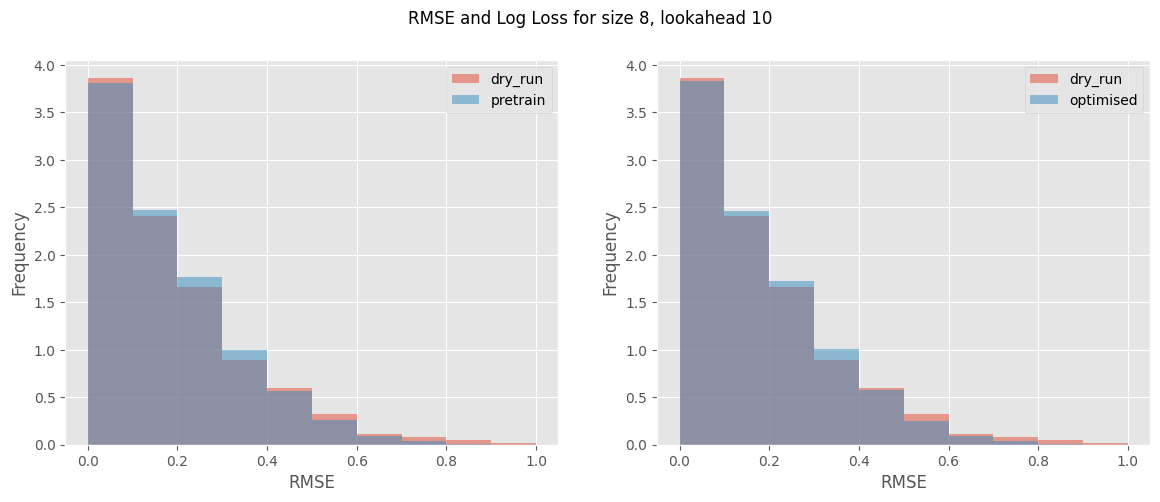

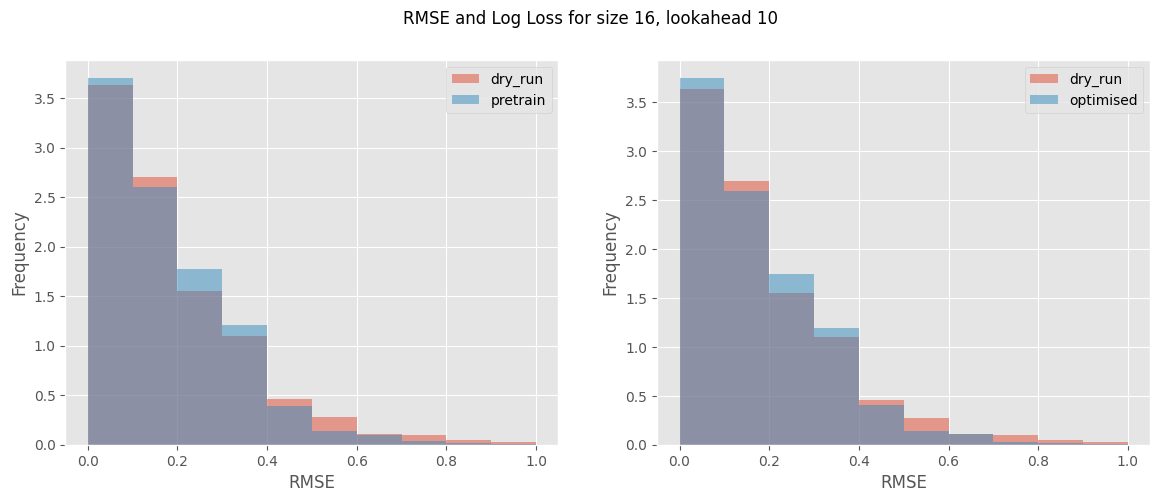

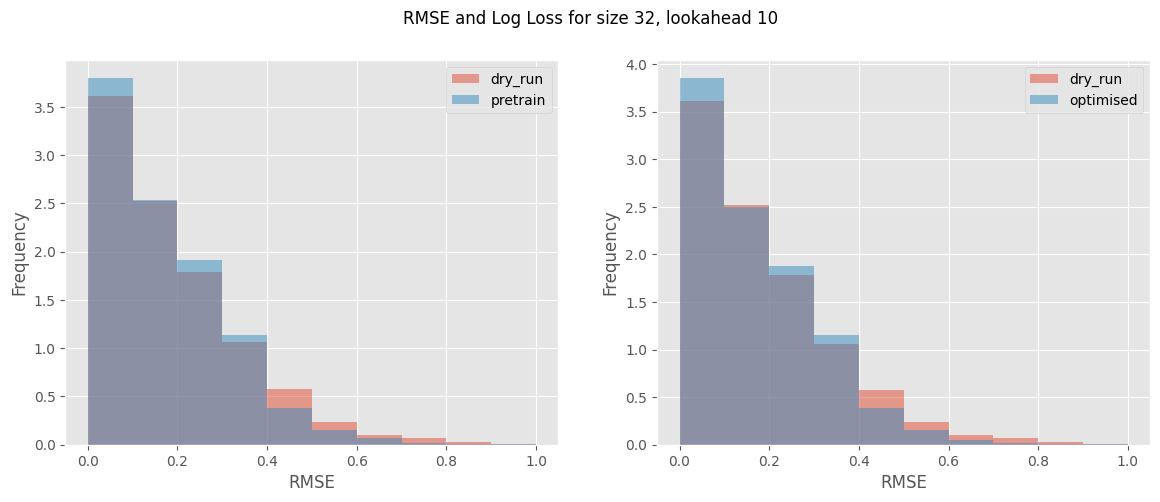

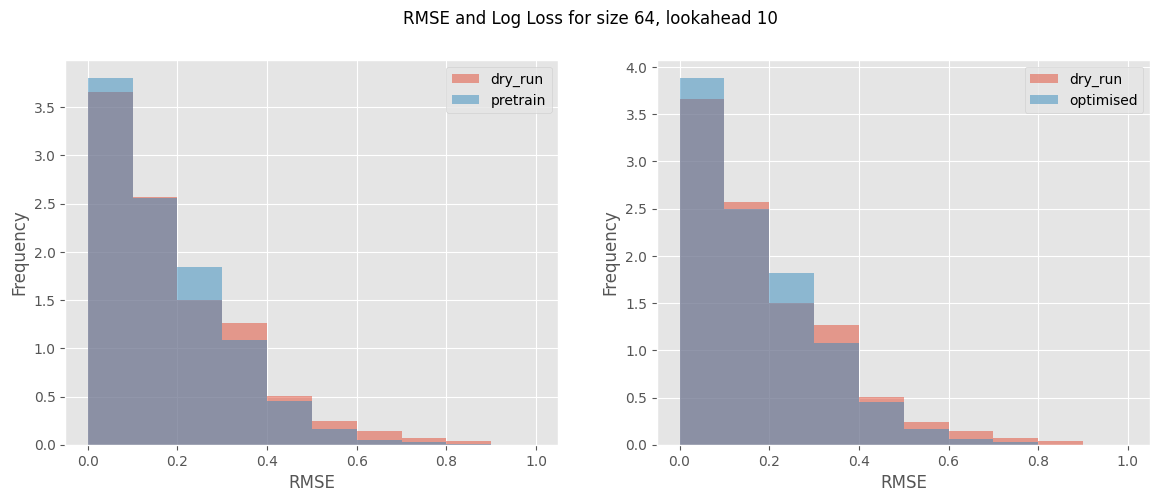

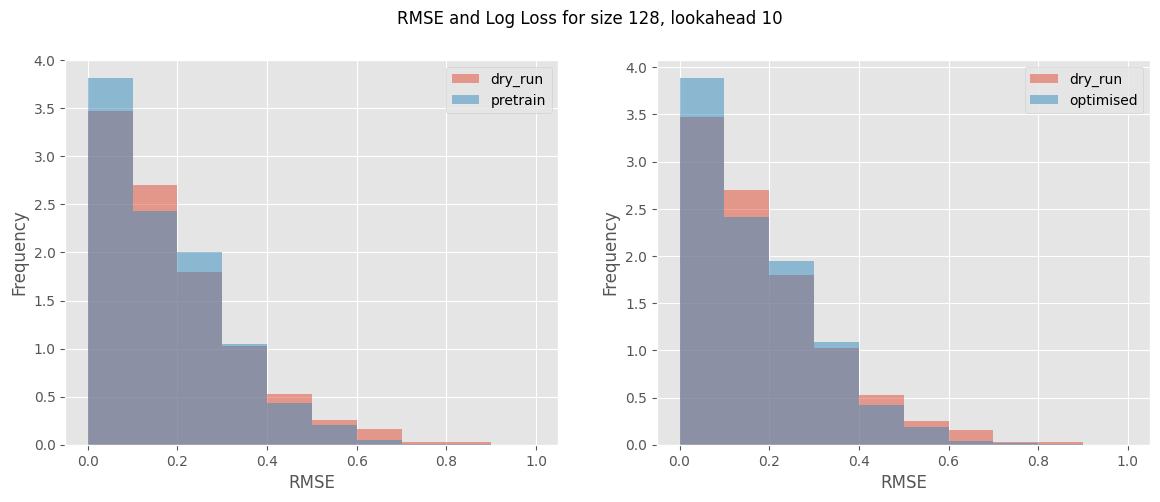

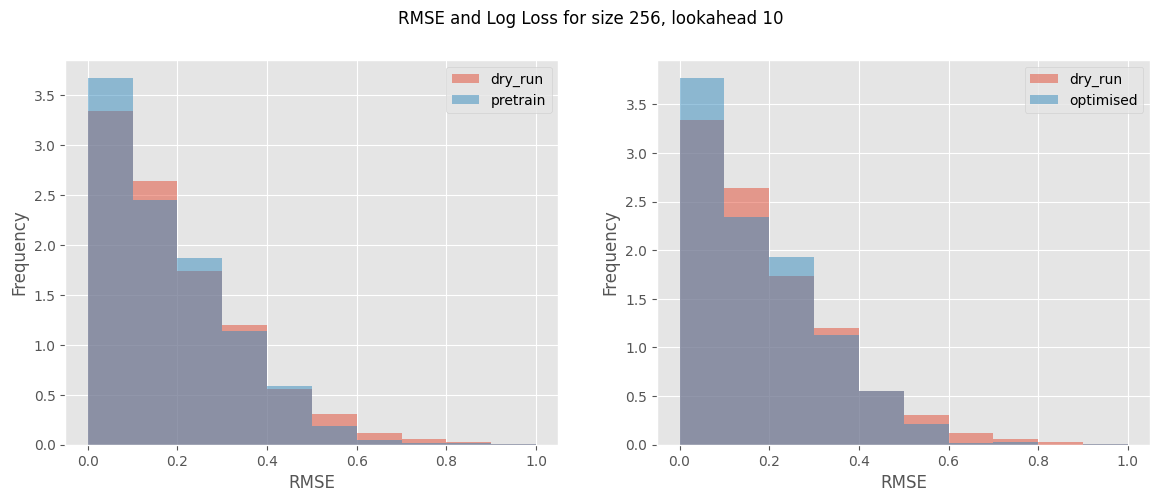

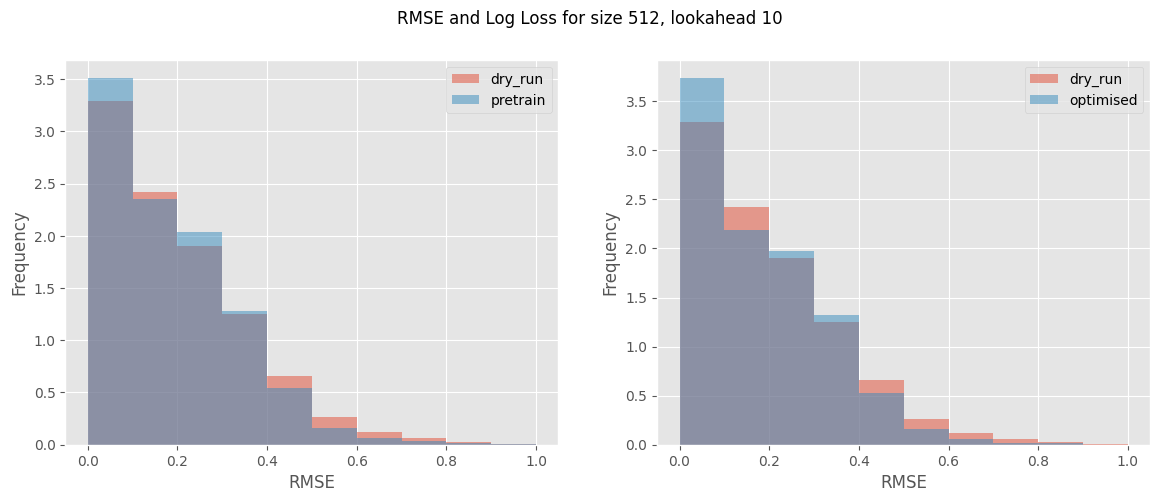

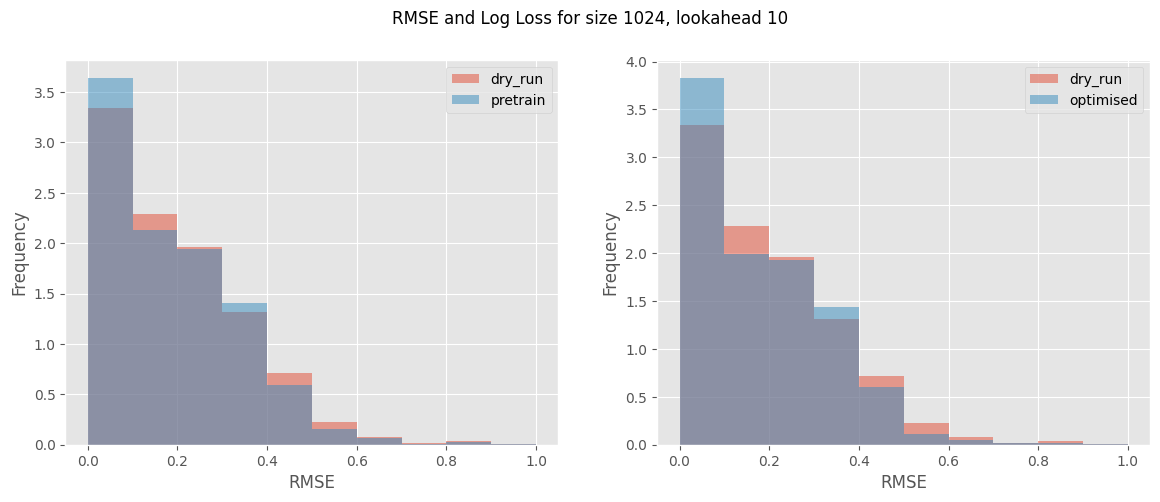

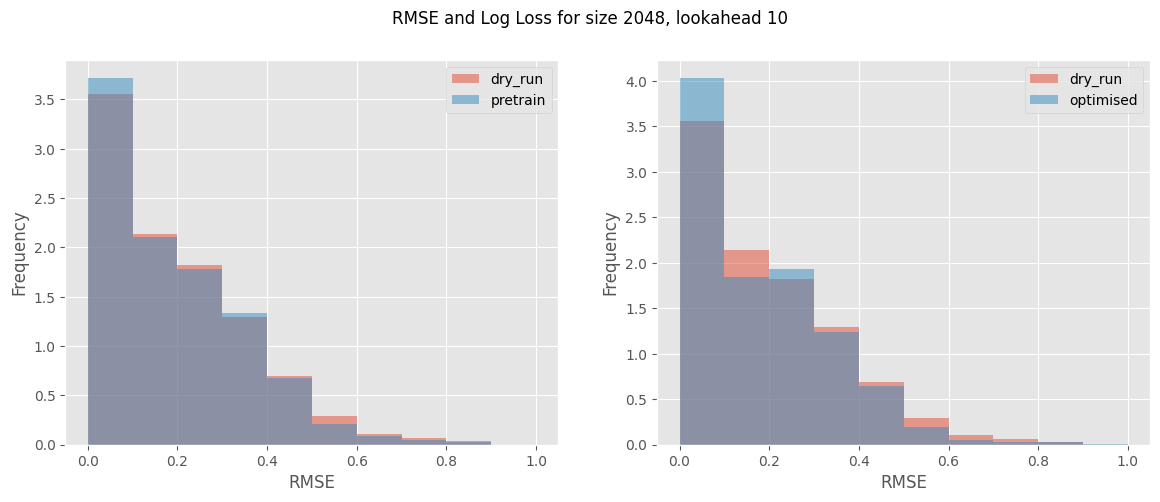

In [57]:

plt.style.use("ggplot")

# Get data
amt_to_do = 2000
look_ahead = 10

cumulative_data = [[], [], []]
for i in range(amt_to_do):
    print('\rGraph', i+1, '', end='')
    try:
        _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=look_ahead, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=False)#, look_aheads=[3, 5, 10, 25, 50, 100, 250, 500, 1000])
    except Exception as e:
        print('Error:', e)
print()
save_cache()

# Convert to cumulative values for look_ahead
indexes = [2**i for i in range(3, 12 + 1)]

cumulative_vals = [[], [], []]  # cumulative_vals[model_index][size_index] = RMSEs
for i in range(3):
    this_vals = [[] for _ in range(len(indexes))]
    for this_rmses in cumulative_data[i]:
        for j, rmse in enumerate(this_rmses):
            if j >= len(indexes):
                break
            this_vals[j].append(rmse)
    for j in range(len(indexes)):
        cumulative_vals[i].append(this_vals[j])

# Plot histograms of RMSE for each size
print("The high ends (worst case scenarios) are reduced by optimised FSRS, especially at higher n(reviews)")
for size_index,size in enumerate(indexes):
    to_plot1 = []
    to_plot2 = []

    for model_i in [2,1]:  # 0 is optimised, 1 is pretrain, 2 is dry_run (default parameters)
        RMSE_list = np.array(cumulative_vals[model_i][size_index])
        # Remove bins with no samples
        if len(RMSE_list) < 200:
            continue
        # Plot loss histograms, each model is offset slightly so they don't overlap
        to_plot1.append((RMSE_list, ['optimised', 'pretrain', 'dry_run'][model_i]))
    
    for model_i in [2,0]:  # 0 is optimised, 1 is pretrain, 2 is dry_run (default parameters)
        RMSE_list = np.array(cumulative_vals[model_i][size_index])
        # Remove bins with no samples
        if len(RMSE_list) < 200:
            continue
        # Plot loss histograms, each model is offset slightly so they don't overlap
        to_plot2.append((RMSE_list, ['optimised', 'pretrain', 'dry_run'][model_i]))
    
    if len(to_plot1) == 0:
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    for e0,e1 in to_plot1:
        bins = [e for e in np.arange(0, max(*e0, 1)+0.1, 0.1)]
        ax1.hist(e0, bins=bins, alpha=0.5, label=e1, density=True)

    for e0,e1 in to_plot2:
        bins = [e for e in np.arange(0, max(*e0, 1)+0.1, 0.1)]
        ax2.hist(e0, bins=bins, alpha=0.5, label=e1, density=True)

    ax1.set_xlabel("RMSE")
    ax1.set_ylabel("Frequency")
    ax2.set_xlabel("RMSE")
    ax2.set_ylabel("Frequency")
    fig.suptitle(f"RMSE and Log Loss for size {size}, lookahead {look_ahead}")
    ax1.legend()
    ax2.legend()
    plt.show()
